# Exploring the diffusion equation with Python

Most of what follows (except the Python code and the bit on fault scarps) is based on and inspired by Slingerland and Kump (2011): [Mathematical Modeling of Earth's Dynamical Systems](http://www.amazon.com/dp/0691145148/ref=cm_sw_r_tw_dp_iG3Wub0YJKYJK), Princeton University Press.  The purpose is to go through the whole process of discretizing a partial differential equation, setting up a numerical scheme, and solving the resulting system of equations in Python and IPython notebook. I am learning this as I am doing it, so it may seem pedestrian and slow-moving to a lot of people but I am sure there are others who will find it useful.

## Estimating the derivatives in the diffusion equation using the Taylor expansion

This is the one-dimensional diffusion equation:

$$ \frac{\partial T}{\partial t} - D\frac{\partial^2 T}{\partial x^2} = 0 $$

Taylor expansion of value of a function $u$ at a point $\Delta x$ ahead of the point $x$ where the function is known:

$$ u(x+\Delta x) = u(x) + \Delta x \frac{\partial u}{\partial x} + \frac{\Delta x^2}{2} \frac{\partial^2 u}{\partial x^2} + \frac{\Delta x^3}{6} \frac{\partial^3 u}{\partial x^3} + O(\Delta x^4) $$

Taylor expansion of value of the function $u$ at a point one space step behind:

$$ u(x-\Delta x) = u(x) - \Delta x \frac{\partial u}{\partial x} + \frac{\Delta x^2}{2} \frac{\partial^2 u}{\partial x^2} - \frac{\Delta x^3}{6} \frac{\partial^3 u}{\partial x^3} + O(\Delta x^4) $$

Solving the first Taylor expansion above for $\frac{\partial u}{\partial x}$ and dropping all higher-order terms yields the forward difference operator:

$$ \frac{\partial u}{\partial x} = \frac{u(x+\Delta x)-u(x)}{\Delta x} + O(\Delta x) $$

Similarly, the second equation yields the backward difference operator:

$$ \frac{\partial u}{\partial x} = \frac{u(x)-u(x-\Delta x)}{\Delta x} + O(\Delta x) $$

Subtracting the second equation from the first one gives the centered difference operator:

$$ \frac{\partial u}{\partial x} = \frac{u(x+\Delta x)-u(x-\Delta x)}{2\Delta x} + O(\Delta x^2) $$

The centered difference operator is more accurate than the other two.

Finally, if the two Taylor expansions are added, we get an estimate of the second order partial derivative:

$$ \frac{\partial^2 u}{\partial x^2} = \frac{u(x+\Delta x)-2u(x)+u(x-\Delta x)}{\Delta x^2} + O(\Delta x^2) $$

Next we use the forward difference operator to estimate the first term in the diffusion equation:

$$ \frac{\partial T}{\partial t} = \frac{T(t+\Delta t)-T(t)}{\Delta t} $$

The second term is expressed using the estimation of the second order partial derivative:

$$ \frac{\partial^2 T}{\partial x^2} = \frac{T(x+\Delta x)-2T(x)+T(x-\Delta x)}{\Delta x^2} $$

Now the diffusion equation can be written as

$$ \frac{T(t+\Delta t)-T(t)}{\Delta t} - D \frac{T(x+\Delta x)-2T(x)+T(x-\Delta x)}{\Delta x^2} = 0 $$

This is equivalent to

$$ T(t+\Delta t) - T(t) - \frac{D\Delta t}{\Delta x^2}(T(x+\Delta x)-2T(x)+T(x-\Delta x)) = 0 $$

The expression $ D\frac{\Delta t}{\Delta x^2} $ is called the diffusion number, denoted here with $s$:

$$ s = D\frac{\Delta t}{\Delta x^2} $$

## FTCS explicit scheme and analytic solution

If we use $n$ to refer to indices in time and $j$ to refer to indices in space, the above equation can be written as

$$ T[n+1,j] = T[n,j] + s(T[n,j+1]-2T[n,j]+T[n,j-1]) $$

This is called a forward-in-time, centered-in-space (FTCS) scheme. Its 'footprint' looks like this:

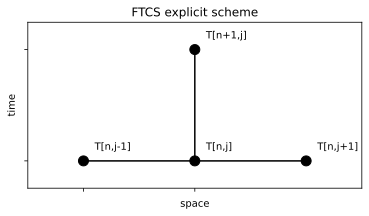

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # display plots in SVG format

fig = plt.figure(figsize=(6,3))
plt.plot([0,2],[0,0],'k')
plt.plot([1,1],[0,1],'k')
plt.plot([0,1,2,1],[0,0,0,1],'ko',markersize=10)
plt.text(1.1,0.1,'T[n,j]')
plt.text(0.1,0.1,'T[n,j-1]')
plt.text(1.1,1.1,'T[n+1,j]')
plt.text(2.1,0.1,'T[n,j+1]')
plt.xlabel('space')
plt.ylabel('time')
plt.axis('equal')
plt.yticks([0.0,1.0],[])
plt.xticks([0.0,1.0],[])
plt.title('FTCS explicit scheme',fontsize=12)
plt.axis([-0.5,2.5,-0.5,1.5]);

Now we are ready to write the code that is the solution for exercise 2 in Chapter 2 of Slingerland and Kump (2011). This is an example where the one-dimensional diffusion equation is applied to viscous flow of a Newtonian fluid adjacent to a solid wall. If the wall starts moving with a velocity of 10 m/s, and the flow is assumed to be laminar, the velocity profile of the fluid is described by the equation

$$ \frac{\partial V}{\partial t} - \nu \frac{\partial^2 V}{\partial y^2} = 0 $$

where $\nu$ is the kinematic viscosity of the fluid. We want to figure out how the velocity will change through time as a function of distance from the wall. [Note that I have changed the original 40 m/s to 10 m/s -- the former seems like an unnaturally large velocity to me].

We can compare the numerical results with the analytic solution, which is known for this problem:

$$ V = V_0 \Big\{ \sum\limits_{n=0}^\infty erfc\big(2n\eta_1+\eta\big) - \sum\limits_{n=0}^\infty erfc\big(2(n+1)\eta_1+\eta\big) \Big\}  $$

where

$$ \eta_1 = \frac{h}{2\sqrt{\nu t}} $$

and

$$ \eta = \frac{y}{2\sqrt{\nu t}} $$

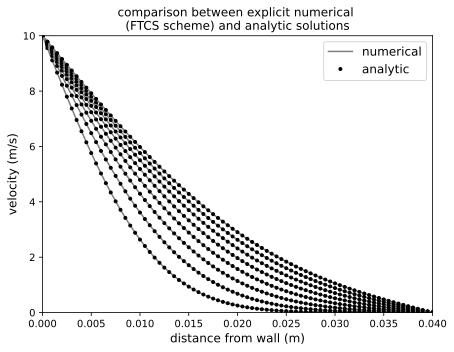

In [2]:
dt = 0.0005 # grid size for time (s)
dy = 0.0005 # grid size for space (m)
viscosity = 2*10**(-4) # kinematic viscosity of oil (m2/s)
y_max = 0.04 # in m
t_max = 1 # total time in s
V0 = 10 # velocity in m/s

# function to calculate velocity profiles based on a finite difference approximation to the 1D diffusion equation and the 
# FTCS (forward-in-time, centered-in-space) scheme:
def diffusion_FTCS(dt,dy,t_max,y_max,viscosity,V0):
    # diffusion number (has to be less than 0.5 for the solution to be stable):
    s = viscosity*dt/dy**2 
    y = np.arange(0,y_max+dy,dy) 
    t = np.arange(0,t_max+dt,dt)
    r = len(t)
    c = len(y)
    V = np.zeros([r,c])
    V[:,0] = V0
    for n in range(0,r-1): # time
        for j in range(1,c-1): # space
            V[n+1,j] = V[n,j] + s*(V[n,j-1] - 2*V[n,j] + V[n,j+1]) 
    return y,V,r,s
# note that this can be written without the for-loop in space, but it is easier to read it this way


from scipy.special import erfc

# function to calculate velocity profiles using the analytic solution:
def diffusion_analytic(t,h,V0,dy,viscosity):
    y = np.arange(0,h+dy,dy)
    eta1 = h/(2*(t*viscosity)**0.5)
    eta = y/(2*(t*viscosity)**0.5)
    sum1 = 0
    sum2 = 0
    for n in range(0,1000):
        sum1 = sum1 + erfc(2*n*eta1+eta)
        sum2 = sum2 + erfc(2*(n+1)*eta1-eta)
    V_analytic = V0*(sum1-sum2)
    return V_analytic

y,V,r,s = diffusion_FTCS(dt,dy,t_max,y_max,viscosity,V0)

# plotting:
plt.figure(figsize=(7,5))
plot_times = np.arange(0.2,1.0,0.1)
for t in plot_times:
    plt.plot(y,V[int(t/dt),:],'Gray',label='numerical')
    V_analytic = diffusion_analytic(t,0.04,10,dy,viscosity)
    plt.plot(y,V_analytic,'ok',label='analytic',markersize=3)
    if t==0.2:
        plt.legend(fontsize=12)
plt.xlabel('distance from wall (m)',fontsize=12)
plt.ylabel('velocity (m/s)',fontsize=12)
plt.axis([0,y_max,0,V0])
plt.title('comparison between explicit numerical \n(FTCS scheme) and analytic solutions');

The dots (analytic solution) overlap pretty well with the lines (numerical solution). However, this would not be the case if we changed the discretization so that the diffusion number was larger. Let's look at the stability of the FTCS numerical scheme, by computing the solution with different diffusion numbers. It turns out that the diffusion number $s$ has to be less than 0.5 for the FTCS scheme to remain stable. What follows is a reproduction of Figure 2.7 in Slingerland and Kump (2011):

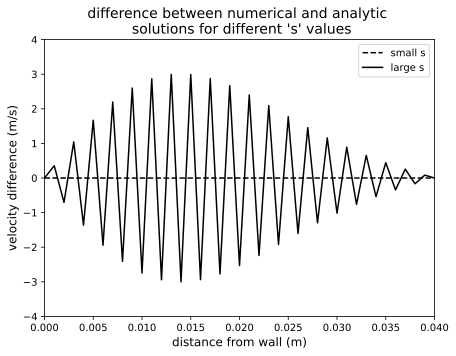

In [3]:
dt = 0.0005 # grid size for time (m)
dy = 0.0005 # grid size for space (s)
y,V,r,s = diffusion_FTCS(dt,dy,t_max,y_max,viscosity,V0)
V_analytic = diffusion_analytic(0.5,0.04,V0,dy,viscosity)
plt.figure(figsize=(7,5))
plt.plot(y,V_analytic-V[int(0.5/dt)],'--k',label='small s')

dy = 0.0010
dt = 0.00254
y,V,r,s = diffusion_FTCS(dt,dy,t_max,y_max,viscosity,V0)
V_analytic = diffusion_analytic(0.5,0.04,V0,dy,viscosity)
V_numeric = V[int(r/2-1),:]

plt.plot(y,V_analytic-V_numeric,'k',label='large s')
plt.xlabel('distance from wall (m)',fontsize=12)
plt.ylabel('velocity difference (m/s)',fontsize=12)
plt.title('difference between numerical and analytic \n solutions for different \'s\' values',fontsize=14)
plt.axis([0,y_max,-4,4])
plt.legend();

## Laasonen implicit scheme

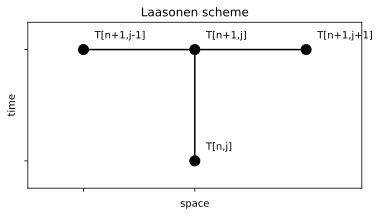

In [4]:
plt.figure(figsize=(6,3))
plt.plot([0,2],[1,1],'k')
plt.plot([1,1],[0,1],'k')
plt.plot([0,1,2,1],[1,1,1,0],'ko',markersize=10)
plt.text(1.1,0.1,'T[n,j]')
plt.text(0.1,1.1,'T[n+1,j-1]')
plt.text(1.1,1.1,'T[n+1,j]')
plt.text(2.1,1.1,'T[n+1,j+1]')
plt.xlabel('space')
plt.ylabel('time')
plt.axis('equal')
plt.yticks([0.0,1.0],[])
plt.xticks([0.0,1.0],[])
plt.title('Laasonen scheme',fontsize=12)
plt.axis([-0.5,2.5,-0.5,1.5]);

Instead of estimating the velocity at time step $n+1$ with the curvature calculated at time step $n$, as it is done in the FTCS explicit scheme, we can also estimate the curvature at time step $n+1$, using the velocity change from time step $n$ to time step $n+1$:

$$ s\big(T(x+\Delta x)-2T(x)+T(x-\Delta x)\big) = T(t+\Delta t)-T(t) $$

Written in matrix notation, this is equiavlent to

$$ s\big(T[n+1,j+1]-2T[n+1,j]+T[n+1,j-1]\big) = T[n+1,j]-T[n,j] $$

After some reshuffling we get

$$ -sT[n+1,j+1] + (1+2s)T[n+1,j] - sT[n+1,j-1] = T[n,j] $$

This is the Laasonen fully implicit scheme. Unlike the FTCS scheme, the Laasonen scheme is unconditionally stable. Let's try to write some Python code that implements this scheme. First it is useful for me to go through the logic of constructing the system of equations that needs to be solved. Let's consider a grid that only consists of 5 nodes in space and we are going to estimate the values of $T$ at the locations marked by the red dots in the figure below. Black dots mark the locations where we already know the values of $T$ (from the initial and boundary conditions).

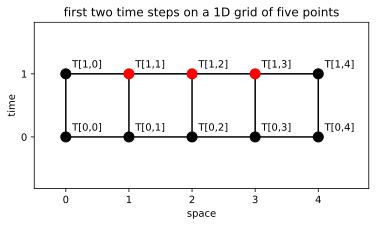

In [5]:
plt.figure(figsize=(6,3))
plt.plot([0,4,4,0],[0,0,1,1],'k')
for i in range(0,4):
    plt.plot([i,i],[0,1],'k')
plt.plot([0,1,2,3,4,0,4],[0,0,0,0,0,1,1],'ko',markersize=10)
plt.plot([1,2,3],[1,1,1],'ro',markersize=10)
for i in range(0,5):
    plt.text(i+0.1,0.1,'T[0,'+str(i)+']')
    plt.text(i+0.1,1.1,'T[1,'+str(i)+']')
plt.xlabel('space')
plt.ylabel('time')
plt.axis('equal')
plt.yticks([0.0,1.0],['0','1'])
plt.title('first two time steps on a 1D grid of five points',fontsize=12)
plt.axis([-0.5,4.8,-0.5,1.5]);

First we write the equations using the Laasonen scheme centered on the three points of unknown velocity (or temperature) -- these are the red dots in the figure above:

$$ \begin{array}{rrrrrcl} 
-sT[1,0]&+(1+2s)T[1,1]&-sT[1,2]&+0T[1,3]&+0T[1,4]&=&T[0,1] \\
0T[1,0]&-sT[1,1]&+(1+2s)T[1,2]&-sT[1,3]&+0T[1,4]&=&T[0,2] \\
0T[1,0]&+0T[1,1]&-sT[1,2]&+(1+2s)T[1,3]&-sT[1,4]&=&T[0,3]
\end{array} $$

It may seem like we have five unknowns and only three equations but $T[1,0]$ and $T[1,4]$ are on the boundaries and they are known. Let's rearrange the equation system so that the left hand side has ony the unknowns:

$$ \begin{array}{rrrrcrr} 
(1+2s)T[1,1]&-sT[1,2]&+0T[1,3]&=&T[0,1]&+sT[1,0] \\
-sT[1,1]&+(1+2s)T[1,2]&-sT[1,3]&=&T[0,2]& \\
0T[1,1]&-sT[1,2]&+(1+2s)T[1,3]&=&T[0,3]&+sT[1,4]
\end{array} $$

In matrix form this is equivalent to

$$ \begin{bmatrix} 1+2s & -s & 0 \\
-s & 1+2s & -s \\
0 & -s & 1+2s \end{bmatrix} \times 
\left[ \begin{array}{c} T[1,1] \\ T[1,2] \\ T[1,3] \end{array} \right]
= \left[ \begin{array}{c} T[0,1]+sT[1,0] \\ T[0,2] \\ T[0,3]+sT[1,4] \end{array} \right] $$

This of course can be extended to larger dimensions than shown here. 
Now we are ready to write the code for the Laasonen scheme. One important difference relative to what I did in the explicit scheme example is that in this case we only keep the last two versions of the velocity distribution in memory, as opposed to preallocating the full array of $nt \times ny$ size as we did before. This difference is not a significant time saver for simple problems like this but once you start dealing with more complicated tasks and code it is not possible and/or practical to keep the results of all time steps in memory.

In [6]:
from scipy.sparse import diags
def diffusion_Laasonen(dt,dy,t_max,y_max,viscosity,V0,V1):
    s = viscosity*dt/dy**2  # diffusion number
    y = np.arange(0,y_max+dy,dy) 
    t = np.arange(0,t_max+dt,dt)
    nt = len(t) # number of time steps
    ny = len(y) # number of dy steps
    V = np.zeros((ny,)) # initial condition
    V[0] = V0 # boundary condition on left side
    V[-1] = V1 # boundary condition on right side
    A = diags([-s, 1+2*s, -s], [-1, 0, 1], shape=(ny-2, ny-2)).toarray() # create coefficient matrix
    for n in range(nt): # time is going from second time step to last
        Vn = V #.copy()
        B = Vn[1:-1] # create matrix of knowns on the RHS of the equation
        B[0] = B[0]+s*V0
        B[-1] = B[-1]+s*V1
        V[1:-1] = np.linalg.solve(A,B) # solve the equation using numpy
    return y,t,V,s

Because this is a stable scheme, it is possible to get reasonable solutions with relatively large time steps (which was not possible with the FTCS scheme):

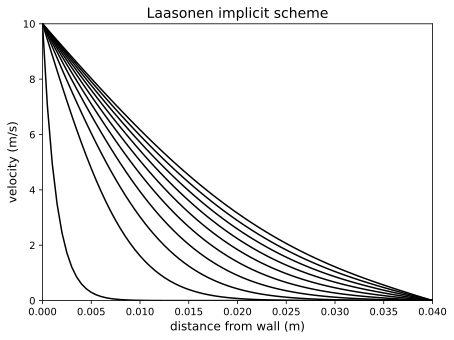

In [7]:
dt = 0.01 # grid size for time (s)
dy = 0.0005 # grid size for space (m)
viscosity = 2*10**(-4) # kinematic viscosity of oil (m2/s)
y_max = 0.04 # in m
V0 = 10.0 # velocity in m/s
V1 = 0.0 # velocity in m/s

plt.figure(figsize=(7,5))
for time in np.linspace(0,1.0,10):
    y,t,V,s = diffusion_Laasonen(dt,dy,time,y_max,viscosity,V0,V1)
    plt.plot(y,V,'k')
plt.xlabel('distance from wall (m)',fontsize=12)
plt.ylabel('velocity (m/s)',fontsize=12)
plt.axis([0,y_max,0,V0])
plt.title('Laasonen implicit scheme',fontsize=14);

Just for fun, let's see what happens if we set in motion the right side of the domain as well; that is, set $V_1$ to a non-zero value:

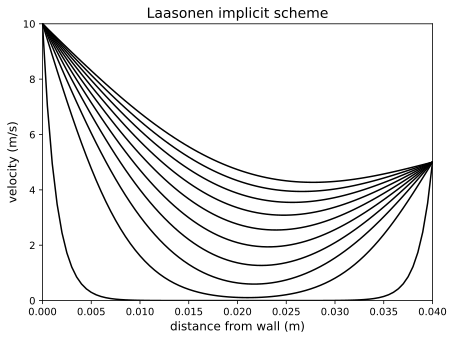

In [8]:
dt = 0.01 # grid size for time (s)
dy = 0.0005 # grid size for space (m)
viscosity = 2*10**(-4) # kinematic viscosity of oil (m2/s)
y_max = 0.04 # in m
V0 = 10.0 # velocity in m/s
V1 = 5.0 # velocity in m/s

plt.figure(figsize=(7,5))
for time in np.linspace(0,1.0,10):
    y,t,V,s = diffusion_Laasonen(dt,dy,time,y_max,viscosity,V0,V1)
    plt.plot(y,V,'k')
plt.xlabel('distance from wall (m)',fontsize=12)
plt.ylabel('velocity (m/s)',fontsize=12)
plt.axis([0,y_max,0,V0])
plt.title('Laasonen implicit scheme',fontsize=14);

## Crank-Nicolson scheme

The Crank-Nicholson scheme is based on the idea that the forward-in-time approximation of the time derivative is estimating the derivative at the halfway point between times $n$ and $n+1$, therefore the curvature of space should be estimated there as well. The 'footprint' of the scheme looks like this:

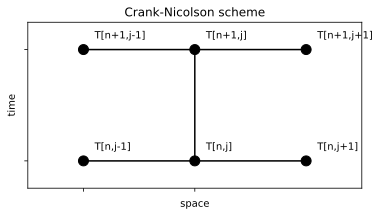

In [9]:
plt.figure(figsize=(6,3))
plt.plot([0,2],[0,0],'k')
plt.plot([0,2],[1,1],'k')
plt.plot([1,1],[0,1],'k')
plt.plot([0,1,2,0,1,2],[0,0,0,1,1,1],'ko',markersize=10)
plt.text(0.1,0.1,'T[n,j-1]')
plt.text(1.1,0.1,'T[n,j]')
plt.text(2.1,0.1,'T[n,j+1]')
plt.text(0.1,1.1,'T[n+1,j-1]')
plt.text(1.1,1.1,'T[n+1,j]')
plt.text(2.1,1.1,'T[n+1,j+1]')
plt.xlabel('space')
plt.ylabel('time')
plt.axis('equal')
plt.yticks([0.0,1.0],[])
plt.xticks([0.0,1.0],[])
plt.title('Crank-Nicolson scheme',fontsize=12)
plt.axis([-0.5,2.5,-0.5,1.5]);

The curvature at the halfway point can be estimated through averaging the curvatures that are calculated at $n$ and $n+1$:

$$ 0.5s\big(T[n+1,j+1]-2T[n+1,j]+T[n+1,j-1]\big) + 0.5s\big(T[n,j+1]-2T[n,j]+T[n,j-1]\big) = T[n+1,j]-T[n,j] $$

This can be rearranged so that terms at $n+1$ are on the left hand side:

$$ -0.5sT[n+1,j-1]+(1+s)T[n+1,j]-0.5sT[n+1,j+1] = 0.5sT[n,j-1]+(1-s)T[n,j]+0.5sT[n,j+1] $$

Just like we did for the Laasonen scheme, we can write the equations for the first two time steps:

\begin{array}{rrrrrcl} 
-0.5sT[1,0] & +(1+s)T[1,1] & -0.5sT[1,2] & = & 0.5sT[0,0] & +(1-s)T[0,1] & +0.5sT[0,2] \\
-0.5sT[1,1] & +(1+s)T[1,2] & -0.5sT[1,3] & = & 0.5sT[0,1] & +(1-s)T[0,2] & +0.5sT[0,3] \\
-0.5sT[1,2] & +(1+s)T[1,3] & -0.5sT[1,4] & = & 0.5sT[0,2] & +(1-s)T[0,3] & +0.5sT[0,4]
\end{array}

Writing this in matrix form, with all the unknowns on the LHS:

$$ \begin{bmatrix} 1+s & -0.5s & 0 \\ -0.5s & 1+s & -0.5s \\ 0 & -0.5s & 1+s \end{bmatrix} \times 
\left[ \begin{array}{c} T[1,1] \\ T[1,2] \\ T[1,3] \end{array} \right]
= \begin{bmatrix} 1-s & 0.5s & 0 \\ 0.5s & 1-s & 0.5s \\ 0 & 0.5s & 1-s \end{bmatrix} \times
\left[ \begin{array}{c} T[0,1] \\ T[0,2] \\ T[0,3] \end{array} \right] +
\left[ \begin{array}{c} 0.5sT[1,0]+0.5sT[0,0] \\ 0 \\ 0.5sT[1,4]+0.5sT[0,4] \end{array} \right] $$

Now we can write the code for the Crank-Nicolson scheme. We will use a new input parameter called $ntout$ that determines how many time steps we want to write out to memory. This way you don't have to re-run the code if you want to plot multiple time steps.

In [10]:
def diffusion_Crank_Nicolson(dy,ny,dt,nt,D,V,ntout):
    Vout = [] # list for storing V arrays at certain time steps
    V0 = V[0] # boundary condition on left side
    V1 = V[-1] # boundary condition on right side
    s = D*dt/dy**2  # diffusion number
    A = diags([-0.5*s, 1+s, -0.5*s], [-1, 0, 1], shape=(ny-2, ny-2)).toarray() # create coefficient matrix
    B1 = diags([0.5*s, 1-s, 0.5*s],[-1, 0, 1], shape=(ny-2, ny-2)).toarray()
    for n in range(1,nt): # time is going from second time step to last
        Vn = V
        B = np.dot(Vn[1:-1],B1) 
        B[0] = B[0]+0.5*s*(V0+V0)
        B[-1] = B[-1]+0.5*s*(V1+V1)
        V[1:-1] = np.linalg.solve(A,B)
        if n % int(nt/float(ntout)) == 0 or n==nt-1:
            Vout.append(V.copy()) # numpy arrays are mutable, so we need to write out a copy of V, not V itself
    return Vout,s

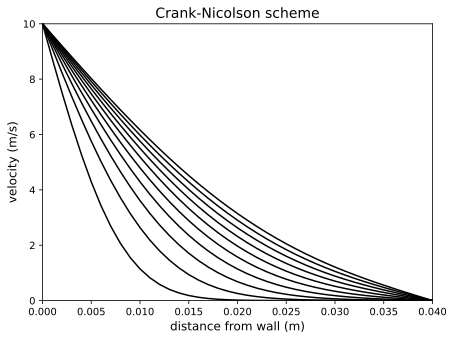

In [11]:
dt = 0.001 # grid size for time (s)
dy = 0.001 # grid size for space (m)
viscosity = 2*10**(-4) # kinematic viscosity of oil (m2/s)
y_max = 0.04 # in m
y = np.arange(0,y_max+dy,dy) 
ny = len(y)
nt = 1000
plt.figure(figsize=(7,5))
V = np.zeros((ny,)) # initial condition
V[0] = 10
Vout,s = diffusion_Crank_Nicolson(dy,ny,dt,nt,viscosity,V,10)

for V in Vout:
    plt.plot(y,V,'k')
plt.xlabel('distance from wall (m)',fontsize=12)
plt.ylabel('velocity (m/s)',fontsize=12)
plt.axis([0,y_max,0,V[0]])
plt.title('Crank-Nicolson scheme',fontsize=14);

## Fault scarp diffusion

So far we have been using a somewhat artificial (but simple) example to explore numerical methods that can be used to solve the diffusion equation. Next we look at a geomorphologic application: the evolution of a fault scarp through time. Although the idea that convex hillslopes are the result of diffusive processes go back to G. K. Gilbert, it was Culling (1960, in the paper [Analytical Theory of Erosion](http://www.jstor.org/stable/30059222)) who first applied the mathematics of the heat equation - that was already well known to physicists at that time - to geomorphology.

Here I used the Crank-Nicolson scheme to model a fault scarp with a vertical offset of 10 m. To compare the numerical results with the analytical solution (which comes from Culling, 1960), I created a function that was written using a Python package for symbolic math called [sympy](http://sympy.org). One of the advantages of sympy is that you can quickly display equations in $\LaTeX$.

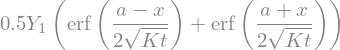

In [13]:
import sympy
from sympy import init_printing
init_printing(use_latex=True)
x, t, Y1, a, K = sympy.symbols('x t Y1 a K')
Y = (1/2.0)*Y1*(sympy.erf((a-x)/(2*sympy.sqrt(K*t))) + sympy.erf((a+x)/(2*sympy.sqrt(K*t))))
Y

The variables in this equation are $x$ - horizontal coordinates, $t$ - time, $a$ - value of $x$ where fault is located, $K$ - diffusion coefficient, $Y_1$ - height of fault scarp.

In [14]:
from sympy.utilities.lambdify import lambdify
f = lambdify((x, t, Y1, a, K), Y, modules=['numpy', 'sympy']) # function for analytic solution

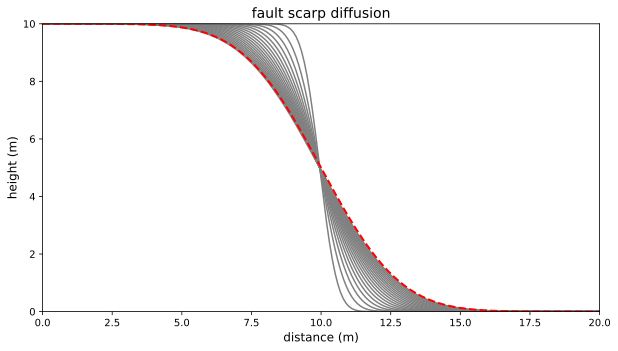

In [15]:
dt = 2.5 # time step (years)
dy = 0.1 # grid size for space (m)
D = 50E-4 # diffusion coefficient in m2/yr - e.g., Fernandes and Dietrich, 1997
h = 10 # height of fault scarp in m
y_max = 20 # length of domain in m
t_max = 500 # total time in years
y = np.arange(0,y_max+dy,dy) 
ny = len(y)
nt = int(t_max/dt)
V = np.zeros((ny,)) # initial condition
V[:round(ny/2.0)] = h # initial condition

Vout,s = diffusion_Crank_Nicolson(dy,ny,dt,nt,D,V,20)

plt.figure(figsize=(10,5.2))
for V in Vout:
    plt.plot(y,V,'gray')

plt.xlabel('distance (m)',fontsize=12)
plt.ylabel('height (m)',fontsize=12)
plt.axis([0,y_max,0,10])
plt.title('fault scarp diffusion',fontsize=14);
plt.plot(y,np.asarray([f(x0, t_max, h, y_max/2.0, D) for x0 in y]),'r--',linewidth=2);

The numerical and analytic solutions (dashed red line) are very similar in this case (total time = 500 years). Let's see what happens if we let the fault scarp evolve for a longer time.

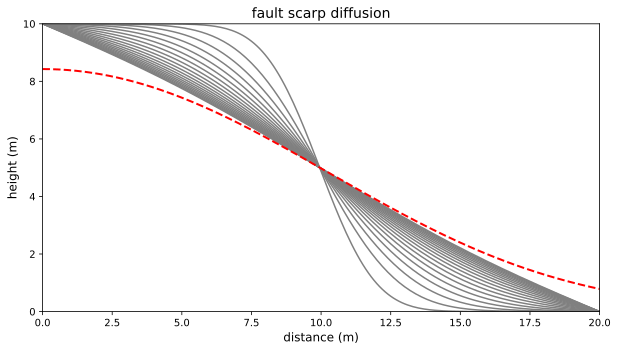

In [16]:
dt = 2.5 # time step (years)
dy = 0.1 # grid size for space (m)
D = 50E-4 # diffusion coefficient in m2/yr - e.g., Fernandes and Dietrich, 1997
h = 10 # height of fault scarp in m
y_max = 20 # length of domain in m
t_max = 5000 # total time in years
y = np.arange(0,y_max+dy,dy) 
ny = len(y)
nt = int(t_max/dt)
V = np.zeros((ny,)) # initial condition
V[:round(ny/2.0)] = h # initial condition

Vout,s = diffusion_Crank_Nicolson(dy,ny,dt,nt,D,V,20)

plt.figure(figsize=(10,5.2))
for V in Vout:
    plt.plot(y,V,'gray')

plt.xlabel('distance (m)',fontsize=12)
plt.ylabel('height (m)',fontsize=12)
plt.axis([0,y_max,0,10])
plt.title('fault scarp diffusion',fontsize=14);
plt.plot(y,np.asarray([f(x0, t_max, h, y_max/2.0, D) for x0 in y]),'r--',linewidth=2);

This doesn't look very good, does it? The reason for the significant mismatch between the numerical and analytic solutions is the fixed nature of the boundary conditions: we keep the elevation at 10 m on the left side and at 0 m on the right side of the domain. There are two ways of getting a correct numerical solution: we either impose boundary conditions that approximate what the system is supposed to do if the elevations were not fixed; or we extend the space domain so that the boundary conditions can be kept fixed throughout the time of interest. Let's do the latter; all the other parameters are the same as above.

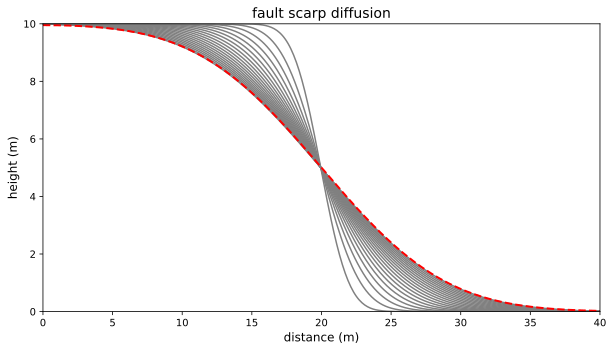

In [17]:
dt = 2.5 # time step (years)
dy = 0.1 # grid size for space (m)
D = 50E-4 # diffusion coefficient in m2/yr - e.g., Fernandes and Dietrich, 1997
h = 10 # height of fault scarp in m
y_max = 40 # length of domain in m
t_max = 5000 # total time in years
y = np.arange(0,y_max+dy,dy) 
ny = len(y)
nt = int(t_max/dt)
V = np.zeros((ny,)) # initial condition
V[:round(ny/2.0)] = h # initial condition

Vout,s = diffusion_Crank_Nicolson(dy,ny,dt,nt,D,V,20)

plt.figure(figsize=(10,5.2))
for V in Vout:
    plt.plot(y,V,'gray')

plt.xlabel('distance (m)',fontsize=12)
plt.ylabel('height (m)',fontsize=12)
plt.axis([0,y_max,0,10])
plt.title('fault scarp diffusion',fontsize=14);
plt.plot(y,np.asarray([f(x0, t_max, h, y_max/2.0, D) for x0 in y]),'r--',linewidth=2);

Now we have a much better result. The vertical dashed lines show the extent of the domain in the previous experiment. We have also gained some insight into choosing boundary conditions and setting up the model domain. It is not uncommon that setting up the initial and boundary conditions is the most time-consuming and difficult part of running a numerical model.

## Further reading

R. Slingerland and L. Kump (2011) [Mathematical Modeling of Earth's Dynamical Systems](http://www.amazon.com/dp/0691145148/ref=cm_sw_r_tw_dp_iG3Wub0YJKYJK)

W. E. H. Culling (1960) [Analytical Theory of Erosion](http://www.jstor.org/stable/30059222)

L. Barba (2013) [12 steps to Navier-Stokes](https://github.com/barbagroup/CFDPython) - an excellent introduction to computational fluid dynamics that uses IPython notebooks

I have blogged before about the geosciency aspects of the diffusion equation over [here](http://hinderedsettling.com/2009/11/26/hillslope-diffusion/).

Questions or suggestions? Contact [@zzsylvester](https://twitter.com/zzsylvester)